# Overview

This notebook conducts an exploratory analysis of sales data, including trend analysis and correlation examination. It also demonstrates the implementation of LSTM (Long Short-Term Memory) models for sales prediction. The models are trained and evaluated using historical sales data, and the notebook provides insights into model performance through visualizations and evaluation metrics.


---

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

low_memory = False

# Load datasets
train = pd.read_csv('train.csv', header=0, parse_dates=['Date'])
test = pd.read_csv('test.csv', header=0, parse_dates=['Date'])
store = pd.read_csv('store.csv', header=0)

# Merge train and test data with store data
train = train.merge(store, on='Store', how='left')
test = test.merge(store, on='Store', how='left')

# Fill missing values
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

# Explore the data
print(train.head())
print(train.info())

/var/folders/38/q0d38hwd0m9g0ls_dbdnz5bh0000gn/T/ipykernel_11355/3732123763.py:12: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('train.csv', header=0, parse_dates=['Date'])


   Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      2          5 2015-07-31   6064        625     1      1            0   
2      3          5 2015-07-31   8314        821     1      1            0   
3      4          5 2015-07-31  13995       1498     1      1            0   
4      5          5 2015-07-31   4822        559     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              1         c          a               1270.0   
1              1         a          a                570.0   
2              1         a          a              14130.0   
3              1         c          c                620.0   
4              1         a          a              29910.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                       11

# Explanation of Code

This code snippet demonstrates how to load and preprocess datasets using pandas and scikit-learn, and then build a LSTM (Long Short-Term Memory) neural network using Keras for predictive modeling.

## Libraries Imported
- **pandas**: Used for data manipulation and analysis.
- **numpy**: Provides support for large, multi-dimensional arrays and matrices, along with a collection of mathematical functions to operate on these arrays.
- **matplotlib.pyplot**: A plotting library for creating static, interactive, and animated visualizations in Python.
- **seaborn**: Built on top of matplotlib, seaborn provides a high-level interface for drawing attractive and informative statistical graphics.
- **sklearn.preprocessing.MinMaxScaler**: Used for scaling numerical features to a specified range, in this case between 0 and 1.
- **keras.models.Sequential**: Provides the core functionality for defining a sequence of neural network layers.
- **keras.layers.LSTM, keras.layers.Dense, keras.layers.Dropout**: Layers used for building LSTM-based neural networks.
  
## Loading and Preprocessing Data
1. **Load Datasets**: Three datasets are loaded from CSV files: `train.csv`, `test.csv`, and `store.csv`.
2. **Merge Data**: The `train` and `test` datasets are merged with the `store` dataset based on the 'Store' column.
3. **Fill Missing Values**: Any missing values in the datasets are filled with 0.

## Exploring the Data
- `print(train.head())` displays the first few rows of the training dataset.
- `print(train.info())` provides information about the training dataset, including the data types and non-null counts of each column.

The code sets `low_memory` to `False`, indicating that pandas should not guess the dtype of each column in the CSV file. This can be useful for large datasets to avoid memory issues during file reading.

This code serves as a foundational step for data preprocessing and model building in a machine learning pipeline.


Date
2013-01-01      97235
2013-01-02    6949829
2013-01-03    6347820
2013-01-04    6638954
2013-01-05    5951593
Name: Sales, dtype: int64


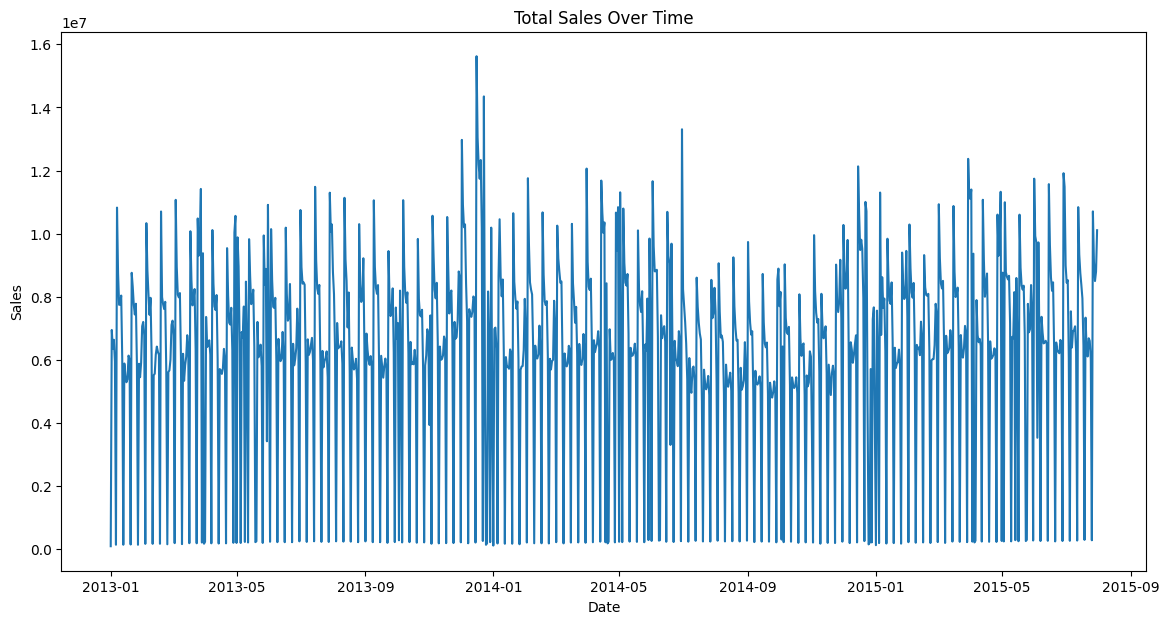

In [110]:
# Analyze sales trends, correlations, etc.
sales_summary = train.groupby('Date')['Sales'].sum()
print(sales_summary.head())

# Plot sales trends
plt.figure(figsize=(14, 7))
plt.plot(sales_summary)
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

# Analyzing Sales Trends

This code snippet analyzes sales trends over time using the training dataset.

## Calculating Sales Summary
- `sales_summary = train.groupby('Date')['Sales'].sum()` aggregates the sales data by date, summing up the sales for each date. This creates a pandas Series object where the index represents dates and the values represent total sales for each date.
- `print(sales_summary.head())` displays the first few entries of the sales summary, providing a glimpse of the aggregated sales data.

## Plotting Sales Trends
- `plt.figure(figsize=(14, 7))` initializes a matplotlib figure with a specified size (width: 14 inches, height: 7 inches) to ensure the plot is visually appealing.
- `plt.plot(sales_summary)` plots the sales summary data on the initialized figure. The x-axis represents dates, and the y-axis represents total sales.
- `plt.title('Total Sales Over Time')` sets the title of the plot to 'Total Sales Over Time'.
- `plt.xlabel('Date')` and `plt.ylabel('Sales')` label the x-axis and y-axis, respectively.
- `plt.show()` displays the plot.

This visualization provides insight into the overall sales trends over time, allowing for the identification of patterns, seasonality, and potential anomalies in the sales data.


In [111]:

import tensorflow as tf

# Seeds for reproductivity
np.random.seed(42)
tf.random.set_seed(42)

# Filter out closed stores
train = train[train['Open'] == 1]

# Sort by date
train.sort_values('Date', inplace=True)

# Extract the sales data
sales_data = train[['Date', 'Sales']].set_index('Date')

# Resample to daily frequency and fill missing values
sales_data = sales_data.resample('D').sum().fillna(0)


# Normalize the sales data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_sales = scaler.fit_transform(sales_data)

# Preprocessing Sales Data for LSTM Model

This code snippet demonstrates the preprocessing steps required to prepare sales data for training an LSTM (Long Short-Term Memory) model using TensorFlow.

## Setting Seeds for Reproducibility
- `np.random.seed(42)` and `tf.random.set_seed(42)` set the random seeds for NumPy and TensorFlow, respectively. This ensures that the random number generation is reproducible across different runs of the code, which is important for debugging and comparing results.

## Filtering Closed Stores and Sorting by Date
- `train = train[train['Open'] == 1]` filters out closed stores from the training dataset, retaining only the data for open stores.
- `train.sort_values('Date', inplace=True)` sorts the training data by date in ascending order. This is important for time-series data analysis and modeling.

## Extracting and Resampling Sales Data
- `sales_data = train[['Date', 'Sales']].set_index('Date')` extracts the sales data from the training dataset and sets the date column as the index.
- `sales_data = sales_data.resample('D').sum().fillna(0)` resamples the sales data to a daily frequency (using 'D' for day) and fills any missing values with 0. This ensures that there is a sales value for every day, even if it's 0.

## Normalizing Sales Data for LSTM
- `scaler = MinMaxScaler(feature_range=(0, 1))` initializes a MinMaxScaler object with a feature range of 0 to 1, which is commonly used for normalizing data for neural networks.
- `scaled_sales = scaler.fit_transform(sales_data)` normalizes the sales data using the MinMaxScaler, scaling the values to the specified feature range.

These preprocessing steps are essential for preparing the sales data to be fed into the LSTM model, ensuring that it is properly formatted and scaled for training.


In [112]:
# Prepare the LSTM input format (features and labels)
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

# Define the time step
time_step = 60  # This means using the past 60 days to predict the next day

# Create the dataset
X, Y = create_dataset(scaled_sales, time_step)

# Reshape the input to be [samples, time steps, features] which is required for LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)

# Creating LSTM Input Dataset

This code snippet demonstrates how to prepare the input dataset for training an LSTM (Long Short-Term Memory) model.

## Creating Dataset Function
- `def create_dataset(data, time_step=1):` defines a function `create_dataset` that takes the scaled sales data and a time step as input parameters.
- The function iterates through the data to create sequences of input features (X) and corresponding labels (Y).
- For each time step, it creates an input sequence (X) by selecting the previous `time_step` days of sales data.
- It creates the corresponding label (Y) by selecting the sales value for the next day.
- The function returns numpy arrays `X` and `Y`, representing the input features and labels, respectively.

## Defining Time Step
- `time_step = 60` sets the time step to 60 days, indicating that the model will use the past 60 days of sales data to predict the sales for the next day.

## Creating Dataset
- `X, Y = create_dataset(scaled_sales, time_step)` calls the `create_dataset` function to create the input dataset using the scaled sales data and the specified time step.
- `X` contains the input features (sequences of past sales data), while `Y` contains the corresponding labels (sales values for the next day).

## Reshaping Input Data
- `X = X.reshape(X.shape[0], X.shape[1], 1)` reshapes the input features `X` to match the required input format for LSTM models, which is `[samples, time steps, features]`.
- Here, `X.shape[0]` represents the number of samples (sequences), `X.shape[1]` represents the number of time steps, and `1` represents the number of features (sales data).

These steps prepare the input dataset in the appropriate format for training the LSTM model, enabling it to learn patterns from historical sales data and make predictions for future sales.


In [113]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping


# Define a complex LSTM model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Increase the number of epochs and use early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)

history = model.fit(X_train, Y_train, epochs=200, batch_size=64, validation_data=(X_test, Y_test), callbacks=[early_stopping], verbose=1)


Epoch 1/200


/Users/michaelwilliams/anaconda3/envs/jupyter_env/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.1193 - val_loss: 0.0478
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0477 - val_loss: 0.0492
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0481 - val_loss: 0.0476
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0456 - val_loss: 0.0455
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0455 - val_loss: 0.0453
Epoch 6/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0447 - val_loss: 0.0453
Epoch 7/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0437 - val_loss: 0.0449
Epoch 8/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0454 - val_loss: 0.0448
Epoch 9/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0451 - val_loss: 0.0447
Epoch 10/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0436 - val_loss: 0.0445
Epoch 11/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0445 - val_loss: 0.0443
Epoch 12/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0

# Building and Training a Complex LSTM Model

This code snippet demonstrates how to define and train a complex LSTM (Long Short-Term Memory) model using Keras.

## Importing Required Modules
- `from keras.models import Sequential`: Imports the `Sequential` class from Keras, which allows for building sequential neural network models.
- `from keras.layers import LSTM, Dense, Dropout`: Imports the LSTM, Dense, and Dropout layers, which are essential components of the neural network architecture.
- `from keras.callbacks import EarlyStopping`: Imports the EarlyStopping callback, which monitors the validation loss during training and stops training early if the loss stops decreasing.

## Defining the Model Architecture
- `model = Sequential()`: Initializes a sequential model.
- `model.add(LSTM(100, return_sequences=True, input_shape=(time_step, X_train.shape[2])))`: Adds an LSTM layer with 100 units, returning sequences (required for subsequent LSTM layers), and specifies the input shape.
- `model.add(LSTM(100, return_sequences=False))`: Adds another LSTM layer with 100 units, but this time does not return sequences.
- `model.add(Dropout(0.2))`: Adds a dropout layer with a dropout rate of 0.2 to prevent overfitting.
- `model.add(Dense(50, activation='relu'))`: Adds a dense layer with 50 units and a ReLU activation function.
- `model.add(Dense(1))`: Adds a dense layer with a single unit, which is the output layer.

## Compiling the Model
- `model.compile(optimizer='adam', loss='mean_squared_error')`: Compiles the model, specifying the Adam optimizer and mean squared error loss function.

## Training the Model
- `early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)`: Initializes an EarlyStopping callback to monitor the validation loss and stop training if it does not improve after 40 epochs.
- `history = model.fit(X_train, Y_train, epochs=200, batch_size=64, validation_data=(X_test, Y_test), callbacks=[early_stopping], verbose=1)`: Trains the model using the training data (`X_train` and `Y_train`) for 200 epochs with a batch size of 64. The validation data (`X_test` and `Y_test`) is used to monitor the model's performance during training, and the EarlyStopping callback is applied to prevent overfitting.

This code snippet illustrates the process of building and training a complex LSTM model for time-series forecasting tasks.


In [114]:
# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Evaluate the model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Transform back to original scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)


# Calculate RMSE for training and testing sets
train_score = np.sqrt(np.mean((train_predict - scaler.inverse_transform(Y_train.reshape(-1, 1)))**2))
test_score = np.sqrt(np.mean((test_predict - scaler.inverse_transform(Y_test.reshape(-1, 1)))**2))

print(f'Train RMSE: {train_score:.2f}')
print(f'Test RMSE: {test_score:.2f}')

# Check the lengths for debugging
print(f"Length of scaled_sales: {len(scaled_sales)}")
print(f"Length of train_predict: {len(train_predict)}")
print(f"Length of test_predict: {len(test_predict)}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Train RMSE: 1384679.14
Test RMSE: 2145640.40
Length of scaled_sales: 942
Length of train_predict: 616
Length of test_predict: 265


# Making Predictions and Evaluating the Model

This code snippet demonstrates how to make predictions using a trained LSTM model and evaluate its performance.

## Making Predictions
- `predictions = model.predict(X_test)`: Uses the trained LSTM model to make predictions on the test dataset (`X_test`).
- `predictions = scaler.inverse_transform(predictions)`: Inverse transforms the scaled predictions back to the original scale using the MinMaxScaler (`scaler`).

## Evaluating the Model
- `train_predict = model.predict(X_train)` and `test_predict = model.predict(X_test)`: Makes predictions on both the training and test datasets to evaluate the model's performance.
- `train_predict = scaler.inverse_transform(train_predict)` and `test_predict = scaler.inverse_transform(test_predict)`: Inverse transforms the scaled predictions on both training and test datasets back to the original scale.
  
## Calculating RMSE (Root Mean Squared Error)
- `train_score = np.sqrt(np.mean((train_predict - scaler.inverse_transform(Y_train.reshape(-1, 1)))**2))` and `test_score = np.sqrt(np.mean((test_predict - scaler.inverse_transform(Y_test.reshape(-1, 1)))**2))`: Calculates the RMSE for both the training and testing sets. It compares the predicted sales values (`train_predict` and `test_predict`) with the actual sales values (`Y_train` and `Y_test`) after inverse transformation.
- The RMSE measures the average magnitude of the errors between predicted and actual values, with lower values indicating better model performance.

## Debugging Information
- `print(f"Length of scaled_sales: {len(scaled_sales)}")`: Prints the length of the scaled sales data, providing information about the size of the dataset used for training the model.
- `print(f"Length of train_predict: {len(train_predict)}")` and `print(f"Length of test_predict: {len(test_predict)}")`: Prints the lengths of the predicted sales values on the training and test datasets, which can be useful for debugging purposes.

This code snippet completes the process of making predictions, evaluating the model's performance, and providing debugging information to assess the effectiveness of the LSTM model for time-series forecasting.


Adjusting test prediction length from 265 to 206


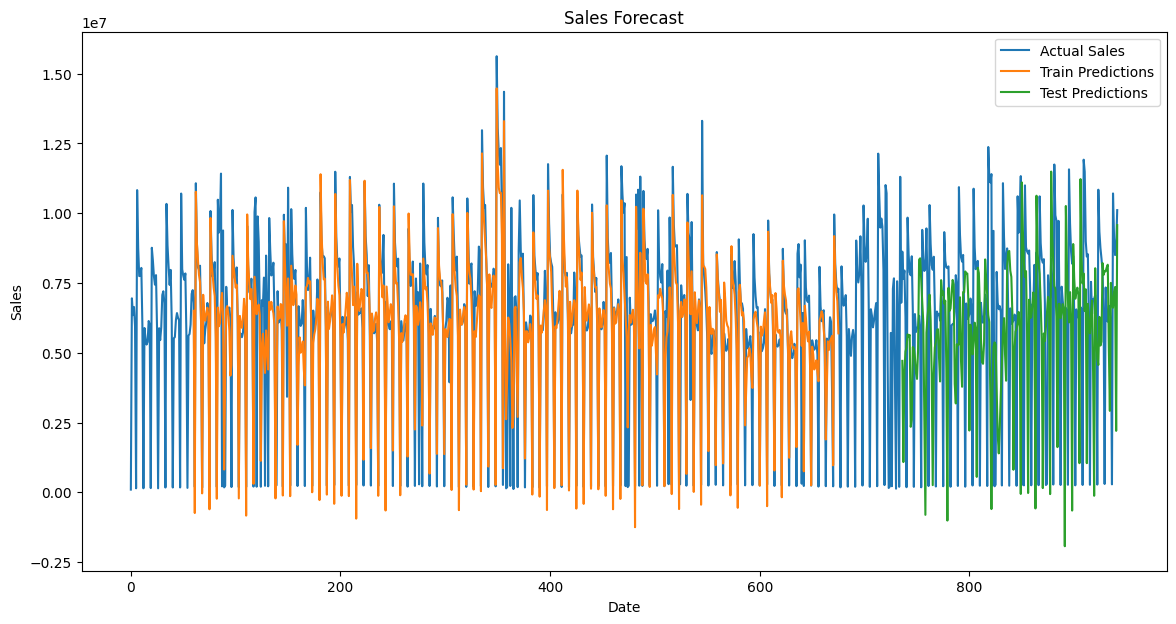

In [115]:
# Create empty arrays for plotting predictions
train_plot = np.empty_like(scaled_sales)
train_plot[:, :] = np.nan
train_plot[time_step:len(train_predict) + time_step, :] = train_predict

test_plot = np.empty_like(scaled_sales)
test_plot[:, :] = np.nan

# Correct indexing for test predictions
# Align test predictions after the training predictions
test_start_index = len(train_predict) + (time_step * 2)
test_end_index = test_start_index + len(test_predict)

# Ensure indices are valid for the length of test_plot
if test_end_index <= len(test_plot):
    test_plot[test_start_index:test_end_index, :] = test_predict
else:
    # Adjust if the calculated index is out of bounds
    valid_length = len(test_plot) - test_start_index
    print(f"Adjusting test prediction length from {len(test_predict)} to {valid_length}")
    test_plot[test_start_index:test_start_index + valid_length, :] = test_predict[:valid_length]

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(scaler.inverse_transform(scaled_sales), label='Actual Sales')
plt.plot(train_plot, label='Train Predictions')
plt.plot(test_plot, label='Test Predictions')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Forecast')
plt.legend()
plt.show()

# Plotting Predictions

This code snippet plots the actual sales data along with the predictions made by the LSTM model on both the training and test datasets.

## Creating Empty Arrays for Plotting Predictions
- `train_plot = np.empty_like(scaled_sales)`: Creates an empty numpy array (`train_plot`) with the same shape as the scaled sales data.
- `train_plot[:, :] = np.nan`: Fills the `train_plot` array with NaN (Not a Number) values to represent missing values.
- `train_plot[time_step:len(train_predict) + time_step, :] = train_predict`: Inserts the predictions made on the training dataset (`train_predict`) into the `train_plot` array. The predictions start from the time step and continue for the length of the training predictions.

- `test_plot = np.empty_like(scaled_sales)`: Creates another empty numpy array (`test_plot`) with the same shape as the scaled sales data.
- `test_plot[:, :] = np.nan`: Fills the `test_plot` array with NaN values.

## Correcting Indexing for Test Predictions
- Calculates the start and end indices for inserting the test predictions into the `test_plot` array, ensuring that they align correctly with the training predictions.

- Checks if the calculated end index is within the valid range of `test_plot`. If it exceeds the length of `test_plot`, it adjusts the length of the test predictions accordingly.

## Plotting the Results
- `plt.figure(figsize=(14, 7))`: Initializes a matplotlib figure with a specified size for plotting.
- `plt.plot(scaler.inverse_transform(scaled_sales), label='Actual Sales')`: Plots the actual sales data after inverse transformation to the original scale using the MinMaxScaler.
- `plt.plot(train_plot, label='Train Predictions')`: Plots the predictions made on the training dataset (`train_plot`).
- `plt.plot(test_plot, label='Test Predictions')`: Plots the predictions made on the test dataset (`test_plot`).
- `plt.xlabel('Date')` and `plt.ylabel('Sales')`: Labels the x-axis and y-axis of the plot, respectively.
- `plt.title('Sales Forecast')`: Sets the title of the plot.
- `plt.legend()`: Displays the legend on the plot to distinguish between actual sales and predictions.
- `plt.show()`: Shows the plot.

This code snippet visualizes the actual sales data along with the predictions made by the LSTM model, providing insights into the model's performance in forecasting sales.
